# Federated Learning (FL) - Titanic

## Objective
Train an ML model of your choice to predict the survival probability in a federated setup and benchmark it against a model being trained on the full dataset.


## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from pathlib import Path

In [2]:
# autoreload changes from local files
%load_ext autoreload
%autoreload 2

# pandas show full output
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 200)

# add module path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src import config
from src import preprocess
from src import visual

## Load data
Observe:
- df_b has a pred column, df_a and df_test do not
- check if formatting is equivalent:
   - ticket naming format differs per dataset
   - age has unrealistic values - babies? Check if they have parents
- feature extraction


In [4]:
df_a = preprocess.load_raw_data_a()
df_a.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
1,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
2,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
3,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
4,21,0,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.0000,NaN,S


## Statistics

In [5]:
print(f'Number of records {df_a.shape[0]} \nNumber of columns: {df_a.shape[1]}')

Number of records 306 
Number of columns: 12


In [6]:
df_a.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,306,306,306,111,306
unique,306,2,254,94,3
top,"McCarthy, Mr. Timothy J",male,S.O.C. 14879,E101,S
freq,1,230,5,3,243


In [7]:
df_a.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,306.000000,306.000000,306.000000,274.000000,306.000000,306.000000,306.000000
mean,449.852941,0.431373,1.601307,34.081204,0.366013,0.339869,39.226893
std,248.973515,0.496079,0.490431,15.422127,0.581142,0.679087,54.911557
min,7.000000,0.000000,1.000000,0.670000,0.000000,0.000000,0.000000
25%,238.250000,0.000000,1.000000,24.000000,0.000000,0.000000,13.000000
50%,453.500000,0.000000,2.000000,32.750000,0.000000,0.000000,26.000000
75%,665.250000,1.000000,2.000000,45.000000,1.000000,0.000000,38.875000
max,890.000000,1.000000,2.000000,80.000000,3.000000,4.000000,512.329200


Missing values per column.
Cabin has too many missing values and thus it's better to remove it. However, Age could be imputed using the median or a more sophisticated multi-variate approach. We favour the latter since the columns like Fare, number of siblings/spouses, and number of parents/children seem quite informative to infer Age.

In [17]:
df_a.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             32
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          195
Embarked         0
dtype: int64

## Visualizations

Drop features that do not contain statistical information to preserve

In [24]:
print(f"Drop features that do not contain statistical information to preserve: {config.FEATURES_DROP}")
df = df_a.drop(config.FEATURES_DROP, axis=1, errors='ignore')

Drop features that do not contain statistical information to preserve: ['PassengerId', 'pred', 'Name', 'Ticket', 'Cabin']


### Univariate

When looking at the boxplot the only column that stands out is Fare, which might have some unrealistic values (i.e. outliers).

<AxesSubplot:>

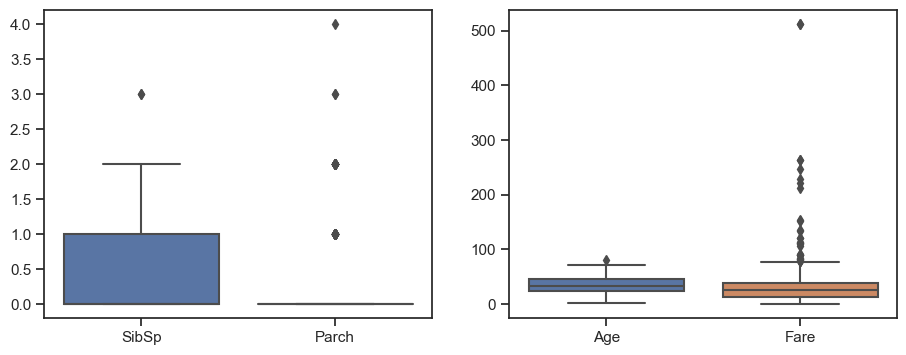

In [33]:
low_range_columns = ['SibSp', 'Parch']
high_range_columns = ['Age', 'Fare']
fig, ax = plt.subplots(1, 2, figsize=(11,4))
sns.boxplot(df[low_range_columns], ax=ax[0])
sns.boxplot(df[high_range_columns], ax=ax[1])

<Figure size 640x480 with 0 Axes>

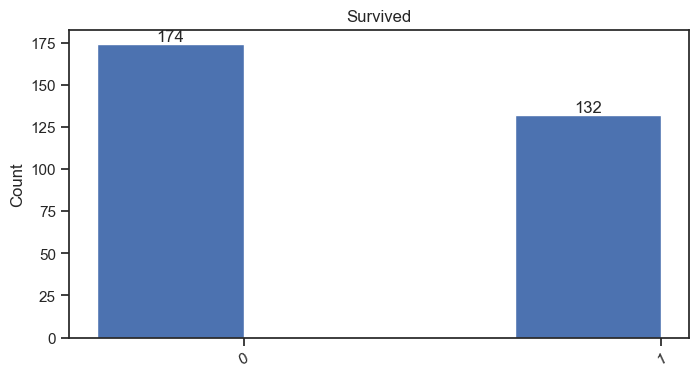

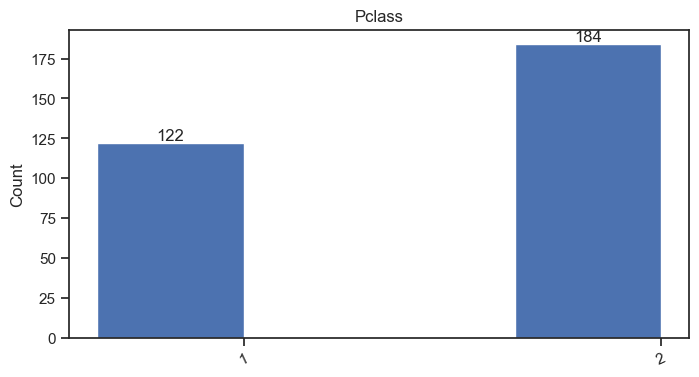

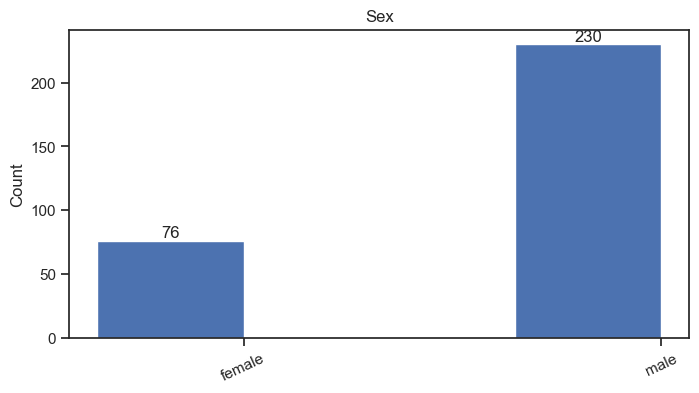

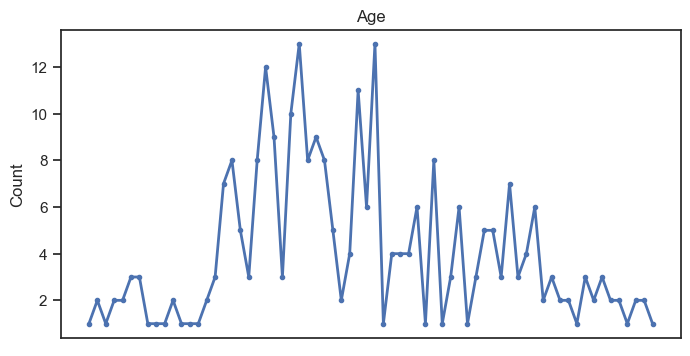

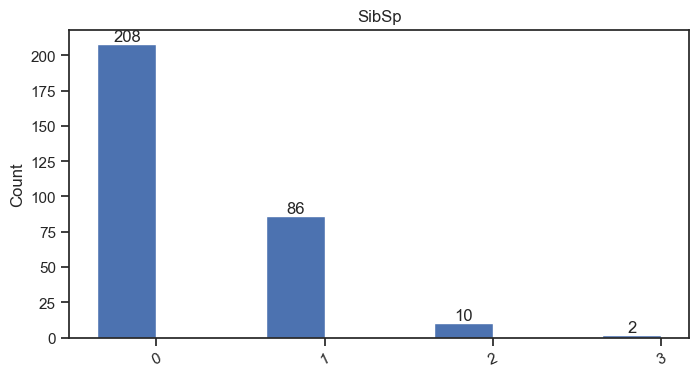

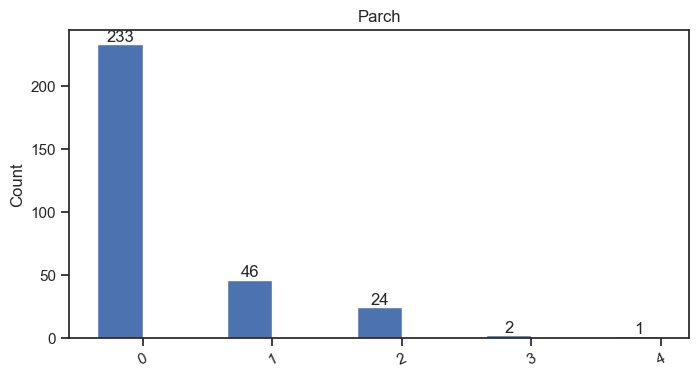

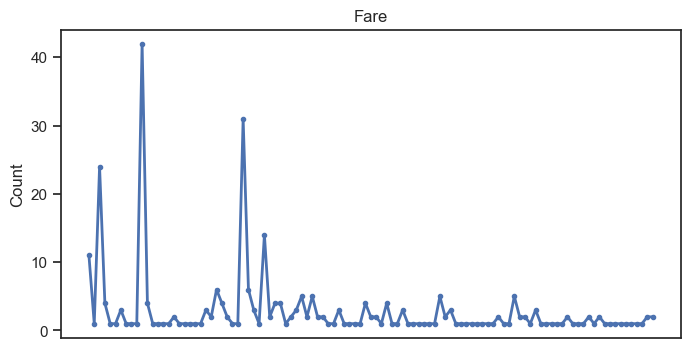

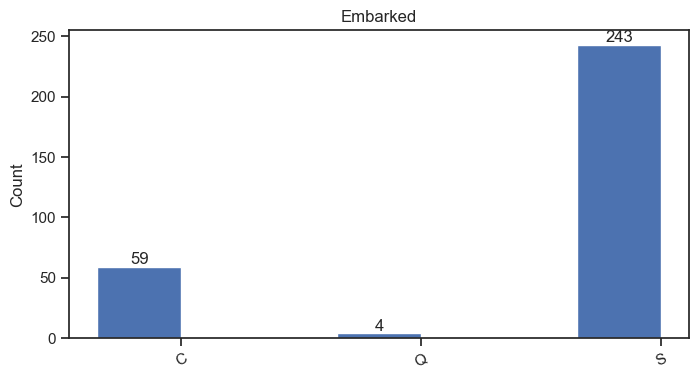

In [21]:
# features = config.FEATURES_NOMINAL + config.FEATURES_ORDINAL + config.FEATURES_RANGE + [config.TARGET]
visual.plot_distributions(df_a.drop(config.FEATURES_DROP, axis=1, errors='ignore'), sort_index=True, dropna=True, normalize=False)

In [46]:
df.Age.min()

0.67

### Multivariate

Below we see the relation between features and the target variabel survived. Observe the following
- Young children (<10) are more likely to survive, while seniors (>65) are less likely to survive.
- There doesn't seem to be a clear seperation between Fare and Survived, except for the outliers.

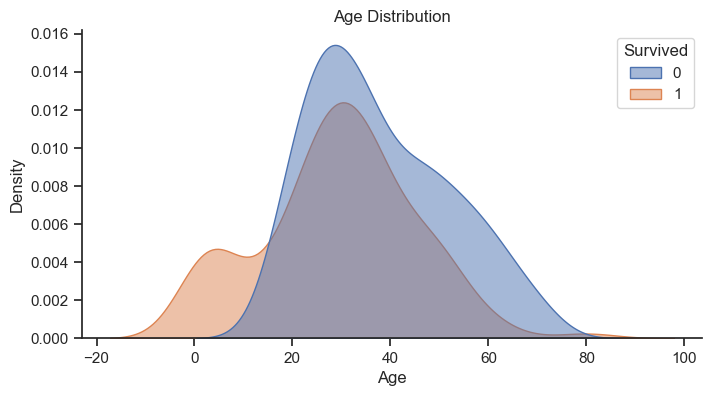

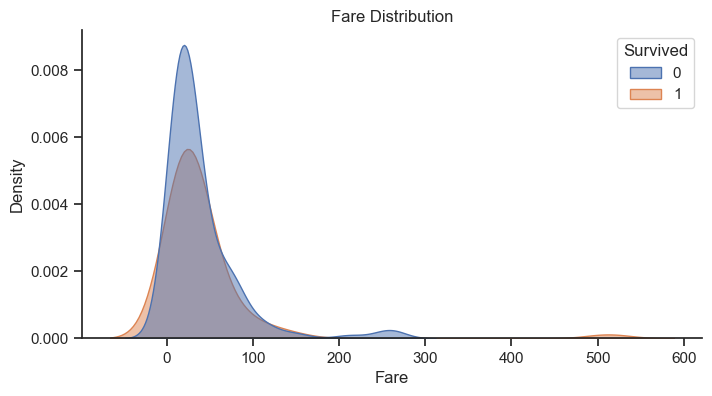

In [59]:
visual.plot_kde(df, x='Age', hue='Survived')
visual.plot_kde(df, x='Fare', hue='Survived')

In [63]:
df.groupby(['Survived'])['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,174.0,38.654620,46.727193,0.0,13.000000,26.00,42.1948,263.0000
1,132.0,39.981252,64.310466,10.5,14.340625,26.25,35.5000,512.3292


When looking at the correlations, none of them are very strong >0.5, however we observe the following:
- Strongest positive correlations:
    - Parch and SibSp: not unexpected, both measure family relations
    - Parch and Fare: the more parents/children you have the more likely you are to pay a higher fare
    - Parch and Survived: the more parents/children you have the more likely you surive.
- Strongest negative correlations:
    - Pclass and Fare: not unexpected, higher fares will put you in upper class (where 1 is upper)
    - Age and Pclass: not unexpected, the older you are the more like you belong to upper class    
    

<AxesSubplot:>

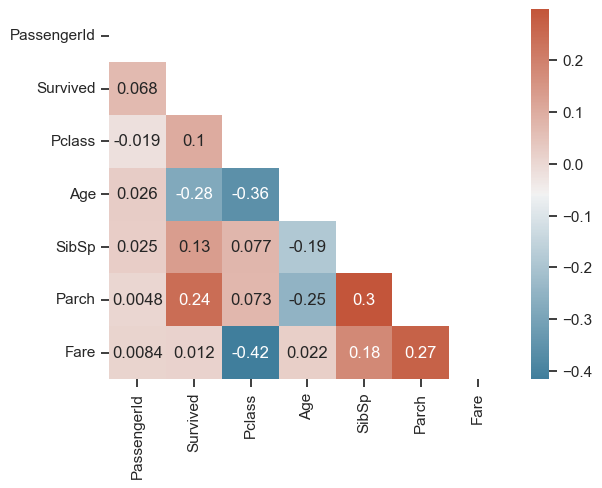

In [60]:
visual.plot_correlation(df_a.corr(), annot=True)

# Train model

In [16]:
df_a.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
1,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
2,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
3,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
4,21,0,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.0000,NaN,S


In [35]:
df_train = df_a[['Pclass', 'Age', 'SibSp', 'Parch', 'Survived']].dropna()
y = np.array(df_train[['Survived']])
X = np.array(df_train.drop(columns='Survived'))


In [33]:
np.isnan(X).sum()

32

In [73]:
class LogiticRegression():
    def __init__(self, solver, threshold=0.5):
        self.solver = solver
        self.threshold=threshold
    
    def predict(self, X):
        y_pred_proba = self.predict_proba(X.T)
        y_pred = (y_pred_proba >= self.threshold).astype(int)
        return y_pred
        
    
    def predict_proba(self, X):
        return self._sigmoid(np.dot(self.coef_.T, X) + self.intercept_)
    
    def fit(self, X, y):
        # init coef and intercept
        self.coef_ = np.zeros_like(X[0])
        self.intercept_ = 0
        
        solver.train(self, X, y)
        return self
    
    def _sigmoid(self, z):
        """Convert prediction to binary class"""
        sig = 1/(1+np.exp(-z))
        return sig

        

class SGD():
    def __init__(self, epochs, learning_rate):
        self.epochs = epochs
        self.learning_rate = learning_rate
        
    def train(self, clf, X, y):
        for epoch in range(0, epochs):
            for i in range(len(X)):
                # compute gradients
                gradient_coef, gradient_intercept = self._compute_gradients(clf, X[i], y[i])
        
                # update parameters
                clf.coef_ = clf.coef_ - (learning_rate*gradient_coef)
                clf.intercept_ = clf.intercept_ - (learning_rate*gradient_intercept)
        return clf
                
        
    def _compute_gradients(self, clf, X, y):
        y_pred = clf.predict_proba(X)
        
        # compute gradients
        gradient_coef = X * (y-y_pred)
        gradient_intercept = y - y_pred
            
        return gradient_coef, gradient_intercept
                
solver = SGD(epochs=500, learning_rate=0.001)
logreg = LogiticRegression(solver)
logreg.fit(X, y)

In [74]:
logreg.predict(X)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [65]:
logreg.coef_

array([ 1.20004635, 28.63588442,  0.25828086,  0.16784909])

In [42]:
coef = np.zeros_like(X[0])
intercept = 0
learning_rate = 0.0001
epochs = 50

def sigmoid(z):
    sig = 1/(1+np.exp(-z))
    return sig

# for every iteration
for epoch in range(0, epochs):

    # todo: turn into batched SGD
    # for every record in X
    for i in range(len(X)):
        # compute prediction
        y_pred = sigmoid(np.dot(coef.T, X[i]) + intercept)
        
        # copmute gradients
        gradient_coef = X[i] * (y[i]-y_pred)
        gradient_intercept = y[i] - y_pred
        
        # update parameters
        coef = coef - (learning_rate*gradient_coef)
        intercept = intercept - (learning_rate*gradient_intercept)

In [49]:
y_pred

array([1.])

In [41]:
coef

array([ 1.20004635, 28.63588442,  0.25828086,  0.16784909])

In [37]:
coef

array([ 1.20004635, 28.63588442,  0.25828086,  0.16784909])

In [22]:
np.array(X)

array([[ 1., 54.,  0.,  0.],
       [ 2., 14.,  1.,  0.],
       [ 2., 55.,  0.,  0.],
       ...,
       [ 2., 28.,  0.,  0.],
       [ 2., 27.,  0.,  0.],
       [ 1., 26.,  0.,  0.]])